# Waste classification (custom CNN, no normalization)

In [7]:
import os, json
from pathlib import Path
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATASET_DIR = ROOT / 'Dataset' / 'RealWaste'
SPLITS_JSON = ROOT / 'Dataset' / 'realwaste_splits.json'
ARTIFACTS_DIR = ROOT / 'artifacts'
ARTIFACTS_DIR.mkdir(exist_ok=True)

Device: cuda


In [8]:
# Check CUDA availability
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA version: {torch.version.cuda}')
    print(f'GPU device: {torch.cuda.get_device_name(0)}')
    print(f'GPU count: {torch.cuda.device_count()}')
else:
    print('No CUDA support detected - will use CPU (slow training)')

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce GTX 1650
GPU count: 1


In [9]:
# Data loading
img_size, batch_size = 224, 64
train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
])
eval_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

with open(SPLITS_JSON, 'r', encoding='utf-8') as f:
    meta = json.load(f)
splits = meta['splits']

class SubsetFromList(datasets.ImageFolder):
    def __init__(self, root, files, transform=None):
        super().__init__(root, transform=transform)
        file_set = set(str(Path(root) / p) for p in files)
        keep = [(path, target) for path, target in self.samples if path in file_set]
        self.samples = keep
        self.imgs = keep

train_ds = SubsetFromList(DATASET_DIR, splits['train'], transform=train_tf)
val_ds = SubsetFromList(DATASET_DIR, splits['val'], transform=eval_tf)
test_ds = SubsetFromList(DATASET_DIR, splits['test'], transform=eval_tf)
class_names = train_ds.classes

pin_mem = (device.type == 'cuda')
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=pin_mem)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin_mem)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin_mem)

print(f'Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}')
print(f'Classes: {class_names}')

Train: 3326, Val: 713, Test: 713
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [10]:
# Model (no BN)
class SimpleCNNNoBN(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(True), nn.MaxPool2d(2), nn.Dropout(dropout),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(True), nn.MaxPool2d(2), nn.Dropout(dropout),
            nn.Conv2d(64,128, 3, padding=1), nn.ReLU(True), nn.MaxPool2d(2), nn.Dropout(dropout),
            nn.Conv2d(128,256,3, padding=1), nn.ReLU(True), nn.MaxPool2d(2), nn.Dropout(dropout),
        )
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(256,128), nn.ReLU(True), nn.Dropout(0.4), nn.Linear(128, num_classes))
    def forward(self, x):
        x = self.features(x); x = self.avg(x); x = self.fc(x); return x
model = SimpleCNNNoBN(num_classes=len(class_names)).to(device)
sum(p.numel() for p in model.parameters())

422473

In [13]:
# Training functions
use_amp = (device.type == 'cuda')
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def train_one_epoch(model, loader, criterion, optim):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optim.zero_grad(set_to_none=True)
        if use_amp:
            with torch.cuda.amp.autocast(enabled=True):
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
        else:
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optim.step()
        loss_sum += loss.item()*x.size(0)
        pred = out.argmax(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, loss_sum = 0, 0.0
    ys, ps = [], []
    ce = nn.CrossEntropyLoss()
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        out = model(x)
        loss = ce(out, y)
        loss_sum += loss.item()*x.size(0)
        total += y.size(0)
        ps.append(out.argmax(1).cpu().numpy())
        ys.append(y.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return loss_sum/total, accuracy_score(y_true, y_pred), confusion_matrix(y_true, y_pred)

# Custom CNN training
EPOCHS = 20  # Increased for better convergence
lr, wd, dropout = 2e-4, 5e-4, 0.45  # Lower LR, less WD, more dropout
model = SimpleCNNNoBN(num_classes=len(class_names), dropout=dropout).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'max', patience=3, factor=0.5)
crit = nn.CrossEntropyLoss(label_smoothing=0.1)
best_val = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

patience = 5  # Early stopping patience
wait = 0
for e in range(1, EPOCHS+1):
    tl, ta = train_one_epoch(model, train_loader, crit, optim)
    vl, va, _ = evaluate(model, val_loader)
    history['train_loss'].append(tl)
    history['train_acc'].append(ta)
    history['val_loss'].append(vl)
    history['val_acc'].append(va)
    scheduler.step(va)
    print(f'Epoch {e:02d}/{EPOCHS} - train_acc {ta:.3f} val_acc {va:.3f} val_loss {vl:.3f}')
    if va > best_val:
        best_val = va
        torch.save({'state_dict': model.state_dict(), 'classes': class_names}, ARTIFACTS_DIR/'custom_cnn_best.pt')
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print('Early stopping triggered.')
            break
print(f'Best validation accuracy: {best_val:.3f}')

Epoch 01/20 - train_acc 0.183 val_acc 0.212 val_loss 2.183
Epoch 02/20 - train_acc 0.189 val_acc 0.212 val_loss 2.179
Epoch 02/20 - train_acc 0.189 val_acc 0.212 val_loss 2.179
Epoch 03/20 - train_acc 0.200 val_acc 0.198 val_loss 2.142
Epoch 03/20 - train_acc 0.200 val_acc 0.198 val_loss 2.142
Epoch 04/20 - train_acc 0.237 val_acc 0.150 val_loss 2.144
Epoch 04/20 - train_acc 0.237 val_acc 0.150 val_loss 2.144
Epoch 05/20 - train_acc 0.252 val_acc 0.168 val_loss 2.109
Epoch 05/20 - train_acc 0.252 val_acc 0.168 val_loss 2.109
Epoch 06/20 - train_acc 0.254 val_acc 0.173 val_loss 2.095
Early stopping triggered.
Best validation accuracy: 0.212
Epoch 06/20 - train_acc 0.254 val_acc 0.173 val_loss 2.095
Early stopping triggered.
Best validation accuracy: 0.212


In [ ]:
# Quick smoke test (1 batch) to validate model + dataloader + AMP
x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to(device, non_blocking=True)
y_batch = y_batch.to(device, non_blocking=True)

model_test = SimpleCNNNoBN(num_classes=len(class_names), dropout=0.3).to(device)
crit_test = nn.CrossEntropyLoss()
optim_test = torch.optim.Adam(model_test.parameters(), lr=1e-3)

use_amp_test = (device.type == 'cuda')
scaler_test = torch.cuda.amp.GradScaler(enabled=use_amp_test)

optim_test.zero_grad(set_to_none=True)
if use_amp_test:
    with torch.cuda.amp.autocast(enabled=True):
        out = model_test(x_batch)
        loss = crit_test(out, y_batch)
    scaler_test.scale(loss).backward()
    scaler_test.step(optim_test)
    scaler_test.update()
else:
    out = model_test(x_batch)
    loss = crit_test(out, y_batch)
    loss.backward()
    optim_test.step()

print({'smoke_test_loss': float(loss.item()), 'batch_size': int(x_batch.size(0)), 'cuda': torch.cuda.is_available()})

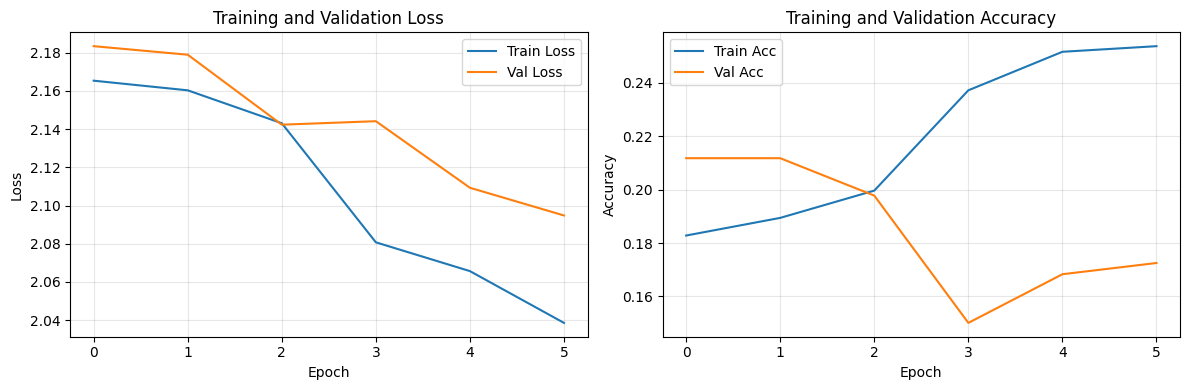

In [14]:
# Training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\Savindu Dilshan\AppData\Local\Temp\ipykernel_23452\2250959704.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ARTIFACTS_DIR/'custom_cnn_best.p

Custom CNN Test Accuracy: 0.390


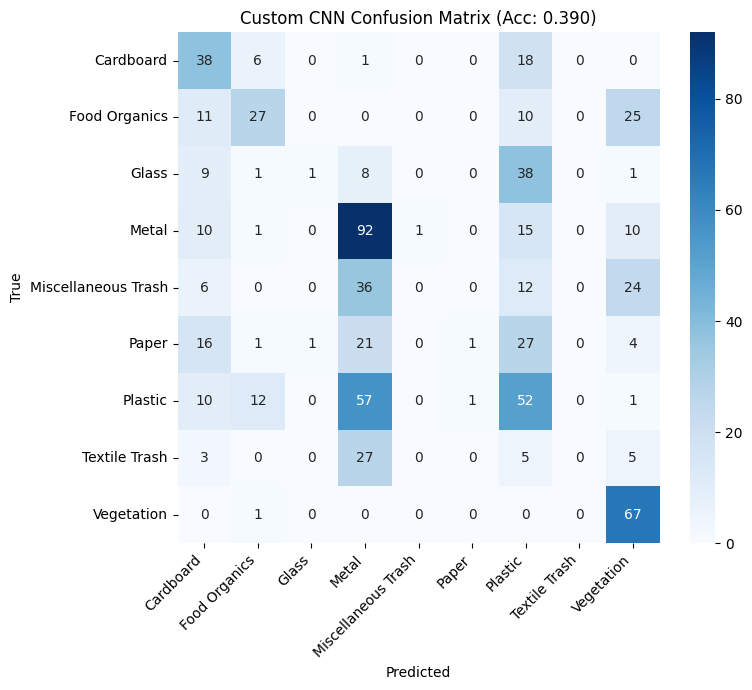

In [ ]:
# Custom CNN - Test evaluation
ckpt = torch.load(ARTIFACTS_DIR/'custom_cnn_best.pt', map_location=device)
model = SimpleCNNNoBN(num_classes=len(class_names), dropout=dropout).to(device)
model.load_state_dict(ckpt['state_dict'])
test_loss, test_acc, cm_custom = evaluate(model, test_loader)
print(f'Custom CNN Test Accuracy: {test_acc:.3f}')

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Custom CNN Confusion Matrix (Acc: {test_acc:.3f})')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Transfer Learning with Pretrained Model (ResNet18)

In [ ]:
# Pretrained ResNet18 with ImageNet normalization
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_tf_pretrain = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
eval_tf_pretrain = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds_pt = SubsetFromList(DATASET_DIR, splits['train'], transform=train_tf_pretrain)
val_ds_pt = SubsetFromList(DATASET_DIR, splits['val'], transform=eval_tf_pretrain)
test_ds_pt = SubsetFromList(DATASET_DIR, splits['test'], transform=eval_tf_pretrain)

train_loader_pt = DataLoader(train_ds_pt, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader_pt = DataLoader(val_ds_pt, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader_pt = DataLoader(test_ds_pt, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Build ResNet18 model
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, len(class_names))
resnet = resnet.to(device)

# Freeze early layers, train only last layers
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.layer4.parameters():
    param.requires_grad = True
for param in resnet.fc.parameters():
    param.requires_grad = True

print(f'Trainable params: {sum(p.numel() for p in resnet.parameters() if p.requires_grad):,}')

In [ ]:
# Train ResNet18
EPOCHS_PT = 20  # More epochs for transfer learning
optim_pt = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-4, weight_decay=5e-5)  # Lower LR, less WD
scheduler_pt = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_pt, 'max', patience=2, factor=0.5)
crit_pt = nn.CrossEntropyLoss()
best_val_pt = 0.0
history_pt = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

patience_pt = 4  # Early stopping for ResNet
wait_pt = 0
for e in range(1, EPOCHS_PT+1):
    tl, ta = train_one_epoch(resnet, train_loader_pt, crit_pt, optim_pt)
    vl, va, _ = evaluate(resnet, val_loader_pt)
    history_pt['train_loss'].append(tl)
    history_pt['train_acc'].append(ta)
    history_pt['val_loss'].append(vl)
    history_pt['val_acc'].append(va)
    scheduler_pt.step(va)
    print(f'Epoch {e:02d}/{EPOCHS_PT} - train_acc {ta:.3f} val_acc {va:.3f} val_loss {vl:.3f}')
    if va > best_val_pt:
        best_val_pt = va
        torch.save({'state_dict': resnet.state_dict(), 'classes': class_names}, ARTIFACTS_DIR/'resnet18_best.pt')
        wait_pt = 0
    else:
        wait_pt += 1
        if wait_pt >= patience_pt:
            print('Early stopping triggered.')
            break
print(f'Best validation accuracy: {best_val_pt:.3f}')

In [ ]:
# ResNet18 training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history_pt['train_loss'], label='Train Loss')
ax1.plot(history_pt['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('ResNet18 - Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_pt['train_acc'], label='Train Acc')
ax2.plot(history_pt['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('ResNet18 - Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ResNet18 - Test evaluation
ckpt_pt = torch.load(ARTIFACTS_DIR/'resnet18_best.pt', map_location=device)
resnet_eval = models.resnet18(pretrained=False)
resnet_eval.fc = nn.Linear(resnet_eval.fc.in_features, len(class_names))
resnet_eval = resnet_eval.to(device)
resnet_eval.load_state_dict(ckpt_pt['state_dict'])
test_loss_pt, test_acc_pt, cm_resnet = evaluate(resnet_eval, test_loader_pt)
print(f'ResNet18 Test Accuracy: {test_acc_pt:.3f}')

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'ResNet18 Confusion Matrix (Acc: {test_acc_pt:.3f})')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Model Comparison Report

In [ ]:
# Comparison summary
import pandas as pd

results = {
    'Model': ['Custom CNN (No BN)', 'ResNet18 (Pretrained)'],
    'Test Accuracy': [f'{test_acc:.3f}', f'{test_acc_pt:.3f}'],
    'Best Val Accuracy': [f'{best_val:.3f}', f'{best_val_pt:.3f}'],
    'Epochs Trained': [EPOCHS, EPOCHS_PT],
    'Architecture': ['4 Conv blocks + FC', 'ResNet18 transfer learning']
}
df = pd.DataFrame(results)
print('\n=== Model Performance Comparison ===\n')
print(df.to_string(index=False))
print('\n' + '='*50)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
models_names = ['Custom CNN', 'ResNet18']
test_accs = [test_acc, test_acc_pt]
val_accs = [best_val, best_val_pt]

axes[0].bar(models_names, test_accs, color=['#3498db', '#2ecc71'], alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(test_accs):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

axes[1].bar(models_names, val_accs, color=['#3498db', '#2ecc71'], alpha=0.7)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Best Validation Accuracy Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(val_accs):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR/'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()